### The goal of this notebook is to explore modifcations to LAISS.

In [6]:
# Install packages
# !pip install numpy pandas pillow astropy matplotlib scikit-learn
# !pip install timeout_decorator
# !pip install gdown
# !pip install confluent-kafka
# !pip install annoy
# !pip install light-curve
# !pip install antares_client
# !pip install astro_ghost

# Download and unpack data
# !gdown -O ../ 131frC1TmAUenZewuHuY2wuOpXLyUji0m
# !unzip -o ../data.zip -d ../

In [1]:
import os

# a silly hack to switch the working directory to the one where this file is located
working_dir = os.path.abspath("")

import time
import datetime
import math
import numpy as np
import pandas as pd
import sys
import astro_ghost
import os
import subprocess
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.spatial.distance import euclidean

os.chdir(working_dir)
sys.path.append('../code/')

from helper_functions import *
from laiss_functions import *
from mod_helper_functions import *
from mod_laiss_functions import *

import requests
from requests.auth import HTTPBasicAuth

import warnings
warnings.filterwarnings("ignore")


## Run LAISS

In [2]:
# Set up file structure for the GHOST code that associates transients with their host galaxies.
host_path = "../data/host_info"
if not os.path.exists(host_path):
    os.makedirs(host_path)

os.environ['GHOST_PATH'] = host_path

#getGHOST(real=False, verbose=False) # Using dummy host-galaxy association database
getGHOST(real=True, verbose=True, installpath='/Users/evanreynolds/Desktop/Physics 90r/er_research_laiss') # Using ghost host database

GHOST database already exists in the install path!


In [3]:
# Choose LAISS features to use
with open("../data/old_host_features.txt") as host_f:
    host_features = [line.strip() for line in host_f.readlines()]

with open("../data/old_lc_features.txt") as lc_f:
    lc_features = [line.strip() for line in lc_f.readlines()]

lc_and_host_features = host_features + lc_features

Run main function, `LAISS`. Arguments are:
* `l_or_ztfid_ref`: The ANTARES or ZTF name for the transient to query. By default, the photometry is retrieved as the first step in the pipeline.
* `lc_features`: The light curve features used in the similarity search. 
* `host_features`: The host-galaxy features used in the similarity search.
* `n`: The number of neighbors to retrieve using ANNOY.
* `use_lc_for_ann_only_bool`: Only uses photometry for the similarity search. This could easily be removed!
* `use_ysepz_phot_snana_file`: Instead of retrieving photometry from the ANTARES website, it can be supplied manually in the `timeseries` folder. 
* `show_lightcurves_grid` and `show_hosts_grid`: Shows the neighbors matched to the queried supernova. 
* `run_AD_model`: Additionally runs the random forest classifier to determine an anomaly score of the event at each observation. This requires both light curve and galaxy features to be calculated!
* `savetables`: Saves the intermediate data from the run.
* `savefigs`: Saves the generated figures. 
*  `ad_params`: The parameters of the specific anomaly detection classifier to load (these will always stay the same, unless we re-train the classifier). 

Loading previously saved ANNOY index
ZTF21aaublej is not in dataset_bank. Checking if made before...
ZTF21aaublej is already made. Continue!

ZTF21aaublej is not in dataset_bank. Checking if made before...
ZTF21aaublej is already made. Continue!

HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=262.60481288+37.00892855&filter=color

Loading previously saved ANNOY LC+HOST index without PCA:
../data/loci_df_271688objects_cut_stars_and_gal_plane_pcaFalse_hostFalse_annoy_index.ann
[27442, 55874, 75309, 47928, 89414, 62821, 7591, 5759]
					   ZTFID IAU_NAME SPEC Z
LC REF: https://alerce.online/object/ZTF21aaublej 2021ixf SN Ia 0.041
HOST REF: https://alerce.online/object/ZTF21aaublej 2021ixf SN Ia 0.041
ANN=0: https://alerce.online/object/ZTF21aaunadg 2021jai SN Ia, 0.02
ANN=1: https://alerce.online/object/ZTF20aczgoml 2020adis SN Ia-91T-like, 0.0453189984
ANN=2: https://alerce.online/object/ZTF21aauapli 2021ixi SN Ia-91T-like, 0.02
ANN=3: https://alerce.online/object/ZTF20acdqjeq 

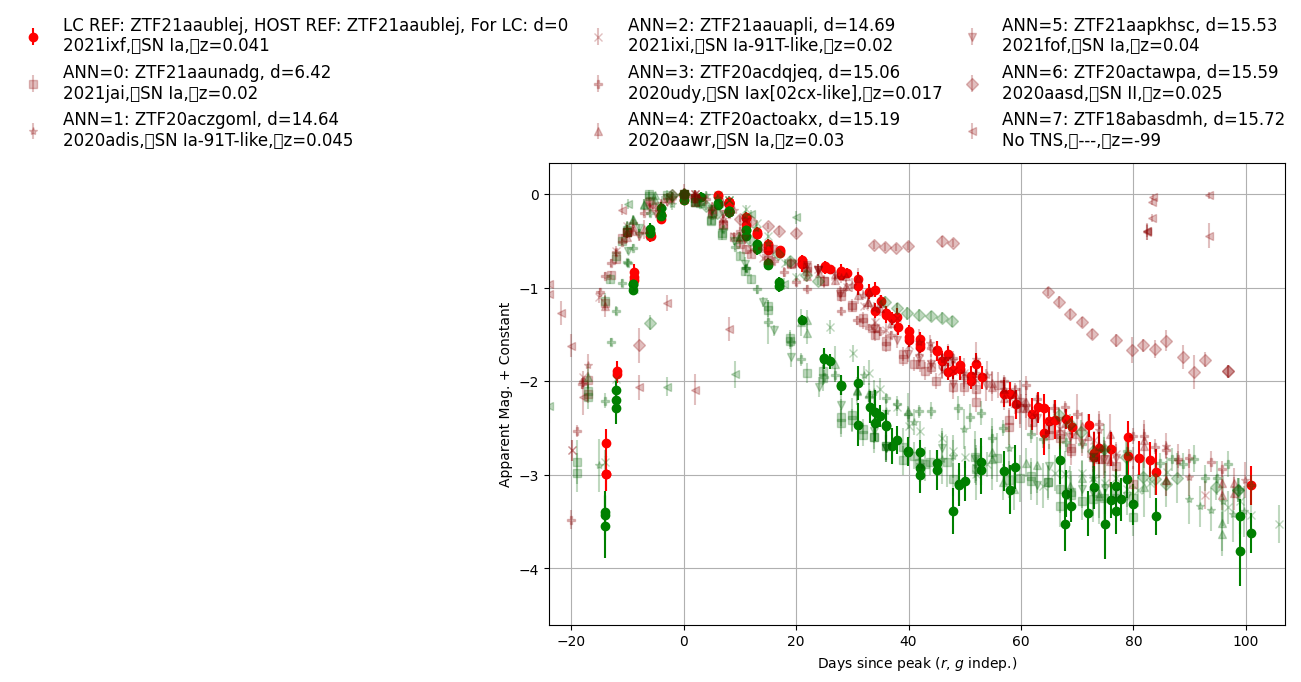

In [4]:
n_estimators = 100
max_depth = 35
random_state = 11
max_features = 35

# Run PCA on light curve and host features to build space of 60 features and build ANNOY index on them
# binary_index_path = "../data/"+mod_build_indexed_sample(fn='../data/dataset_bank_orig_5472objs.csv.gz', lc_features=lc_features, host_features=host_features, pca=True, save=True)
# Or, don't use PCA for (hopefully) more accurate results
binary_index_path = "../data/"+mod_build_indexed_sample(fn='../data/loci_df_271688objects_cut_stars_and_gal_plane.csv', lc_features=lc_features, host_features=[], pca=False, save=True)

# LAISS(l_or_ztfid_ref="ZTF21aaublej",  # ZTF21aaublej or # ZTF22abcvfgs for anomaly
#       lc_features=lc_features,
#       host_features=host_features,
#       n=8,
#       use_lc_for_ann_only_bool=False, # currently doesn't work with YSE_snana_format or ANT IDs 
#       use_ysepz_phot_snana_file=False,
#       show_lightcurves_grid=True,
#       show_hosts_grid=False, # host galaxy images currently don't display properly
#       run_AD_model=True, # needs host features for anomaly detection model
#       savetables=False,
#       savefigs=False, 
#      ad_params={'n_estimators':n_estimators, 'max_depth':max_depth, 'random_state':random_state, 'max_features':max_features})


laiss_dict = LAISS_primer(
    LC_l_or_ztfid_ref="ZTF21aaublej", #ZTF22abcvfgs
    HOST_l_or_ztfid_ref="ZTF21aaublej", #ZTF22abcvfgs
    lc_features=lc_features,
    host_features=host_features,
)

LAISS_nearest_neighbors(
    laiss_dict=laiss_dict,
    use_pca_for_nn=False,
    annoy_index_file_path=binary_index_path,
    n=8,
    search_k=5000,
    show_lightcurves_grid=True,
    store_results=False,
)
    
# LAISS_AD(
#     laiss_dict=laiss_dict,
#     lc_features=lc_features,
#     host_features=host_features,
#     ad_params={'n_estimators':n_estimators, 'max_depth':max_depth, 'random_state':random_state, 'max_features':max_features}
# )

## Bolometric Luminosity / Magnitude Curve

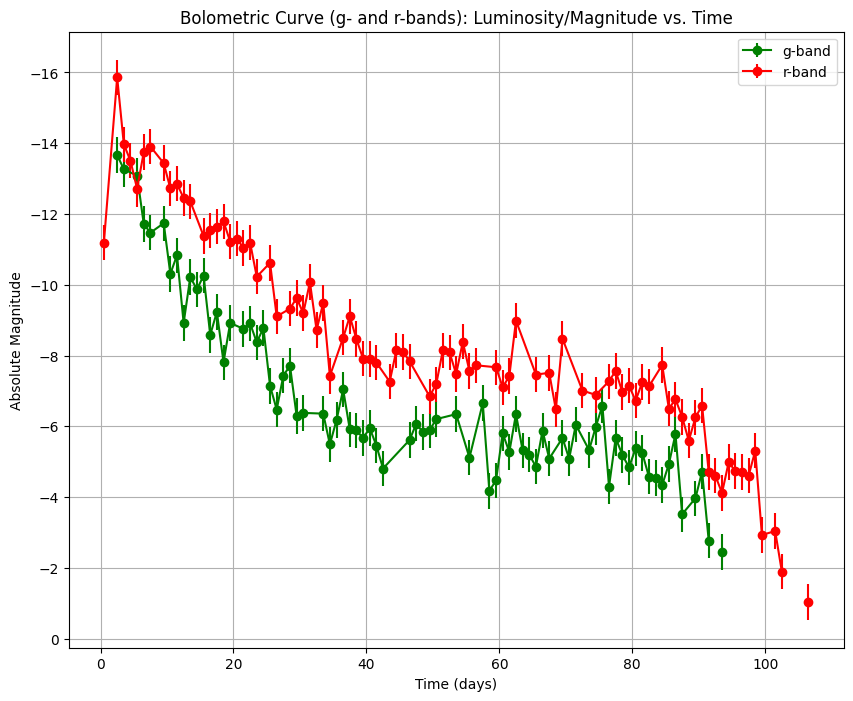

In [11]:
def plot_bolometric_curve(filename, magnitude=False, noise_stddev=0.5, drop_fraction=0.2, separate_bands=False):
    data = np.loadtxt(filename, skiprows=1)

    times = data[:, 0]
    wavelengths = data[:, 1]
    llam = data[:, 2]

    band_ranges = {
        "g": (3676.00, 5613.82),
        "r": (5497.60, 7394.40)
    }

    def calculate_band_luminosity(band):
        band_min, band_max = band_ranges[band]
        mask = (wavelengths >= band_min) & (wavelengths <= band_max)
        band_times = times[mask]
        band_llam = llam[mask]
        unique_times = np.unique(band_times)

        bolometric_luminosity = []
        for time in unique_times:
            total_luminosity = band_llam[band_times == time].sum()
            bolometric_luminosity.append(total_luminosity)
        
        return unique_times, np.array(bolometric_luminosity)

    if separate_bands:
        g_times, g_luminosity = calculate_band_luminosity('g')
        r_times, r_luminosity = calculate_band_luminosity('r')

        if magnitude:
            L0 = 3.828e33  # Reference luminosity (erg/s)
            g_magnitude = -2.5 * np.log10(g_luminosity / L0)
            r_magnitude = -2.5 * np.log10(r_luminosity / L0)

            # Add Gaussian noise and drop data points
            g_noise = np.random.normal(0, noise_stddev, size=g_magnitude.shape)
            r_noise = np.random.normal(0, noise_stddev, size=r_magnitude.shape)
            g_magnitude += g_noise
            r_magnitude += r_noise

            g_num_drop = int(len(g_magnitude) * drop_fraction)
            r_num_drop = int(len(r_magnitude) * drop_fraction)
            g_drop_indices = np.random.choice(len(g_magnitude), g_num_drop, replace=False)
            r_drop_indices = np.random.choice(len(r_magnitude), r_num_drop, replace=False)
            g_magnitude = np.delete(g_magnitude, g_drop_indices)
            r_magnitude = np.delete(r_magnitude, r_drop_indices)
            g_times = np.delete(g_times, g_drop_indices)
            r_times = np.delete(r_times, r_drop_indices)

    else:
        unique_times, bolometric_luminosity = calculate_band_luminosity('g')
        if magnitude:
            L0 = 3.828e33  # Reference luminosity (erg/s)
            bolometric_magnitude = -2.5 * np.log10(bolometric_luminosity / L0)

            # Add Gaussian noise and drop data points
            bolometric_magnitude += np.random.normal(0, noise_stddev, size=bolometric_magnitude.shape)
            num_points_to_drop = int(len(bolometric_magnitude) * drop_fraction)
            drop_indices = np.random.choice(len(bolometric_magnitude), num_points_to_drop, replace=False)
            bolometric_magnitude = np.delete(bolometric_magnitude, drop_indices)
            unique_times = np.delete(unique_times, drop_indices)

    # Convert time from seconds to days
    if separate_bands:
        g_times = g_times / (3600.0 * 24)
        r_times = r_times / (3600.0 * 24)
    else:
        unique_times = unique_times / (3600.0 * 24)

    # Plotting
    plt.figure(figsize=(10, 8))

    if separate_bands:
        if magnitude:
            plt.errorbar(g_times, g_magnitude, yerr=noise_stddev, marker='o', linestyle='-', color='green', label='g-band')
            plt.errorbar(r_times, r_magnitude, yerr=noise_stddev, marker='o', linestyle='-', color='red', label='r-band')
            plt.ylabel('Absolute Magnitude')
        else:
            plt.errorbar(g_times, g_luminosity, yerr=noise_stddev, marker='o', linestyle='-', color='green', label='g-band')
            plt.errorbar(r_times, r_luminosity, yerr=noise_stddev, marker='o', linestyle='-', color='red', label='r-band')
            plt.ylabel('Luminosity (erg/s)')
        plt.title('Bolometric Curve (g- and r-bands): Luminosity/Magnitude vs. Time')
    else:
        if magnitude:
            plt.errorbar(unique_times, bolometric_magnitude, yerr=noise_stddev, marker='o', linestyle='-', color='blue')
            plt.ylabel('Absolute Magnitude')
            plt.title('Bolometric Curve (Total): Magnitude vs. Time')
        else:
            plt.errorbar(unique_times, bolometric_luminosity, yerr=noise_stddev, marker='o', linestyle='-', color='blue')
            plt.ylabel('Luminosity (erg/s)')
            plt.title('Bolometric Curve (Total): Luminosity vs. Time')

    plt.xlabel('Time (days)')
    plt.grid(True)
    if separate_bands:
        plt.legend()
    if magnitude:
        plt.gca().invert_yaxis()
    plt.show()

    # Returning
    if separate_bands:
        if magnitude:
            return g_magnitude, r_magnitude
        else:
            return g_luminosity, r_luminosity
    else:
        if magnitude:
            return bolometric_magnitude
        else:
            return bolometric_luminosity

g_mag, r_mag = plot_bolometric_curve("../data/sed_m60.0_mrp5.57_m560.000.dat", separate_bands=True, magnitude=True)

## To add more transients to your transient_feature_lib (now with ra and dec)

In [13]:
ztf_id = 'ZTF22abcvfgs'

print(
    f"Processing {ztf_id}"
)

storage_df = pd.DataFrame()

feat_df = mod_extract_lc_and_host_features(
    ztf_id_ref=ztf_id,
    use_lc_for_ann_only_bool=False,
    show_lc=False,
    show_host=False,
    host_features=host_features,
    store_csv=False,
)

# Choose LAISS features to use
with open("../data/host_features.txt") as host_f:
    host_features = [line.strip() for line in host_f.readlines()]
with open("../data/lc_features.txt") as lc_f:
    lc_features = [line.strip() for line in lc_f.readlines()]
lc_and_host_features = host_features + lc_features
lc_and_host_features.append("ra")
lc_and_host_features.append("dec")

if feat_df is not None:
    feat_df = feat_df.dropna()
    try:
        lc_and_hosts_df_120d = feat_df[lc_and_host_features]
    except:
        print(f"{ztf_id} has some NaN LC features. Skip!")
        sys.exit()

    anom_obj_df = pd.DataFrame(lc_and_hosts_df_120d.iloc[-1]).T
    anom_obj_df["ztf_id"] = ztf_id
    cols = ["ztf_id"] + [col for col in anom_obj_df.columns if col != "ztf_id"]
    anom_obj_df = anom_obj_df[cols]
    anom_obj_df.reset_index(drop=True, inplace=True)

    storage_df = pd.concat([storage_df, anom_obj_df])


storage_df.to_csv("../SINGLEtransient_feature_lib.csv", index=False)
# with open('../transient_feature_lib0.csv', 'a') as f:
#     storage_df.to_csv(f, header=f.tell()==0, index=False)

Processing ZTF22abcvfgs
Extracted LC features for for ZTF22abcvfgs in 0.68s!
Found no hosts in GLADE.
Finding northern sources with Pan-starrs...
Found matches for 50.0% of events.
122


## To add more neighbor groups to neighbors_lib

In [13]:
lightcurve_ztf_id = 'ZTF22abcvfgs' # This will be the lightcurve of your neighbor group, and it will swap out hosts

binary_index_path = "../data/"+mod_build_indexed_sample(fn='../data/dataset_bank_orig_5472objs.csv.gz', lc_features=lc_features, host_features=host_features, pca=True, save=True)

file_names = [
    'transient_feature_lib0.csv',
    'transient_feature_lib1500.csv',
    'transient_feature_lib2500.csv',
    'transient_feature_lib3000.csv',
    'transient_feature_lib4000.csv',
    'transient_feature_lib5000.csv'
]

# This dataframe has one row for every transient and 121 columns (first column is ztf_id)
laiss_feat_library_df = pd.concat([pd.read_csv("../"+file) for file in file_names], ignore_index=True)

lightcurve_row = laiss_feat_library_df[laiss_feat_library_df['ztf_id'] == lightcurve_ztf_id]
lc_tns_name, lc_tns_cls, lc_tns_z = getTnsData(lightcurve_row['ztf_id'].iloc[0])


output_file = '../data/neighbors_lib.csv'
for index, host_row in laiss_feat_library_df.iterrows():

    # if host_row[0] != lightcurve_ztf_id:
    #     continue

    # get last 62 columns from lightcurve_row (starting at index 59)
    lightcurve_features_data = lightcurve_row.iloc[:, 59:].values.flatten().tolist()
    # get galaxy features (columns 1-59) from host_row
    host_features_data = host_row.iloc[1:59].values.tolist()

    locus_feat_arr = np.array(lightcurve_features_data + host_features_data)

    host_tns_name, host_tns_cls, host_tns_z = getTnsData(host_row[0])
    laiss_test_dict = {
        "HOST_ztfid_ref": host_row[0],
        "HOST_tns_name": host_tns_name,
        "HOST_tns_cls": host_tns_cls,
        "HOST_tns_z": host_tns_z,
        "host_df_ztf_id_l": [],
        "LC_ztfid_ref": lightcurve_row['ztf_id'].iloc[0],
        "LC_tns_name": lc_tns_name,
        "LC_tns_cls": lc_tns_cls,
        "LC_tns_z": lc_tns_z,
        "locus_feat_arr": locus_feat_arr,
        "l_or_ztfid_ref_in_dataset_bank": False,
    }

    neighbors_df = LAISS_nearest_neighbors(
        laiss_dict=laiss_test_dict,
        use_pca_for_nn=True,
        annoy_index_file_path=binary_index_path,
        n=8,
        search_k=1000,
        show_lightcurves_grid=False,
        store_results=True,
    )

    with open(output_file, 'a') as f:
        neighbors_df.to_csv(f, header=f.tell()==0, index=False)

    print(f"Processed host {index} in feature library!")

print("Finished creating neighbor library!")


Loading previously saved ANNOY index
Loading previously saved ANNOY LC+HOST PCA=60 index
../data/dataset_bank_orig_5472objs_pcaTrue_hostTrue_annoy_index.ann
					   ZTFID IAU_NAME SPEC Z
LC REF: https://alerce.online/object/ZTF22abcvfgs 2022vxc SLSN-I 0.1
HOST REF: https://alerce.online/object/ZTF17aaazdba 2019azh TDE 0.022
ANN=0: https://alerce.online/object/ZTF21aaejeyu 2021aip SN Ia, 0.026
ANN=1: https://alerce.online/object/ZTF21aagmryd 2021bjy SN Ia, 0.027489
ANN=2: https://alerce.online/object/ZTF21aacxung 2021yr SN Ia, 0.046118
ANN=3: https://alerce.online/object/ZTF19acwiqrc 2020zcg SN Ia, 0.048
ANN=4: https://alerce.online/object/ZTF19abvgxrq 2019pev ---, -99
ANN=5: https://alerce.online/object/ZTF21aajdbhw 2021cym SN Ia, 0.04
ANN=6: https://alerce.online/object/ZTF20acgkbjz 2020urk SN Ia, 0.047
ANN=7: https://alerce.online/object/ZTF21aabhxxj 2021ls SN Ia, 0.05

ANN elapsed_time = 0.182 s

total elapsed_time = 8.384 s

Processed host 0 in feature library!
Loading previously s

KeyboardInterrupt: 

## Studying neighbor variation when swapping host galaxy

- Creating score function based on rank (and or distance) for each neighbor.

Number of hosts analyzed: 1209
Number of unique nearest neighbors overall: 100
Number of unique nearest neighbors for neighbor 0: 27
Number of unique nearest neighbors for neighbor 1: 41
Number of unique nearest neighbors for neighbor 2: 49
Number of unique nearest neighbors for neighbor 3: 60
Number of unique nearest neighbors for neighbor 4: 60
Number of unique nearest neighbors for neighbor 5: 64
Number of unique nearest neighbors for neighbor 6: 67
Number of unique nearest neighbors for neighbor 7: 76


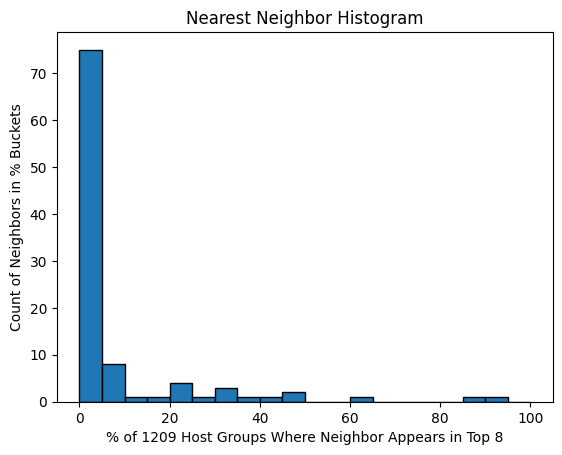

    iau_name  rank_score  avg_rank_score
72   2021ixf        7714        6.380480
71   2021ipb        6529        5.400331
68   2021hdv        3642        3.012407
5   2020aasd        3490        2.886683
89   2021rgw        2267        1.875103
..       ...         ...             ...
38   2020zpi           1        0.000827
40  2021aewn           1        0.000827
82   2021pzt           1        0.000827
75   2021kir           1        0.000827
0    2018gzz           1        0.000827

[100 rows x 3 columns]


In [23]:
df = pd.read_csv('../data/neighbors_lib.csv')
# df = pd.read_csv('../data/neighbors_lib_GHOST_df_version.csv')

df = df.drop_duplicates().reset_index(drop=True, inplace=False)
df = df[df["lightcurve_ztf"] == "ZTF21aaublej"] # ZTF21aaublej or ZTF22abcvfgs


print(f"Number of hosts analyzed: {df['host_ztf'].nunique()}")

# Get total number of unique neighbors
unique_neighbors = df['iau_name'].nunique()
print(f"Number of unique nearest neighbors overall: {unique_neighbors}")

# Get number of unique neighbors for neighbor n
for n in range(0, 8):
    target_neighbors_df = df[df['neighbor_num'] == n]
    unique_neighbors = target_neighbors_df['iau_name'].nunique()
    print(f"Number of unique nearest neighbors for neighbor {n}: {unique_neighbors}")

# Get frequency of neighbor appearance, plot histogram of percentages
neighbor_counts = df['iau_name'].value_counts()
total_host_groups = df['host_ztf'].nunique()

neighbor_percentage = (neighbor_counts / total_host_groups) * 100
plt.hist(neighbor_percentage, bins=range(0, 101, 5), edgecolor='black')
plt.xlabel(f"% of {total_host_groups} Host Groups Where Neighbor Appears in Top 8")
plt.ylabel("Count of Neighbors in % Buckets")
plt.title("Nearest Neighbor Histogram")
plt.show()

# Use scoring system to factor in rank
score_mapping = {i: 8 - i for i in range(8)}
avg_score_mapping = {i: (8 - i)/total_host_groups for i in range(8)}
df['rank_score'] = df['neighbor_num'].map(score_mapping)
#df['rank_score'] = df['neighbor_num'].map(avg_score_mapping)

rank_score_summary = df.groupby('iau_name')['rank_score'].sum().reset_index()
rank_score_summary = rank_score_summary.sort_values(by='rank_score', ascending=False)
rank_score_summary['avg_rank_score'] = rank_score_summary['rank_score'] / total_host_groups
print(rank_score_summary)


# Scoring system based on distance
def plot_distance_difference(df, num):
    target_neighbors = df[df['neighbor_num'] == num]

    real_transient_row = target_neighbors[target_neighbors['lightcurve_ztf'] == target_neighbors['host_ztf']]
    
    if real_transient_row.empty:
        print("No matching lightcurve_ztf and host_ztf found for the specified neighbor_num.")
        return

    # Get distance difference for each neighbor in target_neighbors
    target_neighbors['dist_diff'] = target_neighbors['dist'] - real_transient_row['dist'].values[0]

    # Plot histogram of the distance differences with an overlaid KDE (Kernel Density Estimate) line
    plt.figure(figsize=(10, 6))
    sns.histplot(target_neighbors['dist_diff'], kde=True)
    plt.xlabel("Distance - True Transient-Host Neighbor Distance")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Distances for Neighbor #{num+1}")
    plt.show()

#plot_distance_difference(df, 2)

## Studying feature variation in dataset bank

Index(['ztf_object_id', 'feature_amplitude_magn_r',
       'feature_anderson_darling_normal_magn_r', 'feature_beyond_1_std_magn_r',
       'feature_beyond_2_std_magn_r', 'feature_cusum_magn_r',
       'feature_inter_percentile_range_2_magn_r',
       'feature_inter_percentile_range_10_magn_r',
       'feature_inter_percentile_range_25_magn_r', 'feature_kurtosis_magn_r',
       ...
       'yExtNSigma', 'i-z', 'gApMag_gKronMag', 'rApMag_rKronMag',
       'iApMag_iKronMag', 'zApMag_zKronMag', 'yApMag_yKronMag', '7DCD',
       'dist/DLR', 'type'],
      dtype='object', length=122)
type
SN Ia             985
SN II             229
SN IIn             59
SN Ia-91T-like     35
SN IIb             22
Name: count, dtype: int64


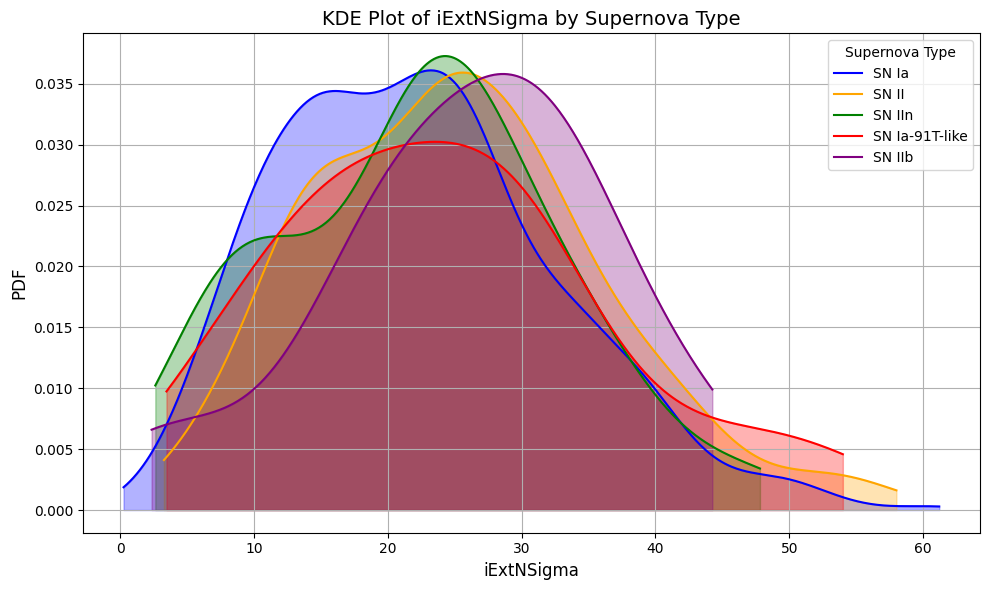

In [2]:
def plot_kde_by_supernova_type(df, feature, start_idx=1, stop_idx=9):
    if feature not in df.columns:
        raise ValueError(f"The feature '{feature}' does not exist in the DataFrame.")
    
    type_counts = df['type'].value_counts()
    top_types = type_counts.index[start_idx:stop_idx]  # Skip the first type (---), take 2nd to 9th with 1:9
    print(type_counts.iloc[start_idx:stop_idx])
    
    df = df[df['type'].isin(top_types)]
    
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'yellow', 'black', 'brown']
    plt.figure(figsize=(10, 6))
    for idx, supernova_type in enumerate(top_types):
        data = df[df['type'] == supernova_type][feature].dropna()
        if len(data) > 1:  # Ensure there is enough data for KDE
            kde = gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 500)
            y_values = kde(x_range)
            
            plt.plot(x_range, y_values, label=supernova_type, color=colors[idx])
            plt.fill_between(x_range, y_values, alpha=0.3, color=colors[idx])
    
    plt.title(f"KDE Plot of {feature} by Supernova Type", fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("PDF", fontsize=12)
    plt.legend(title="Supernova Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend(title="Supernova Type")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


df_bank_tns_cls = pd.read_csv('../dataset_bank_tns_cls.csv')
print(df_bank_tns_cls.columns)
plot_kde_by_supernova_type(df_bank_tns_cls,'iExtNSigma', start_idx=1, stop_idx=6) # Use gApMag_gKronMag or 7DCD # Change 4 to 1 to show variation

Problem lightcurves: ['ZTF21aaabwfu', 'ZTF21aabygea', 'ZTF21aaydxoo'] Dist/DLR values: [10000000000.0, 10000000000.0, 10000000000.0]
Neighbor ZTF ID: ZTF21aatlesr


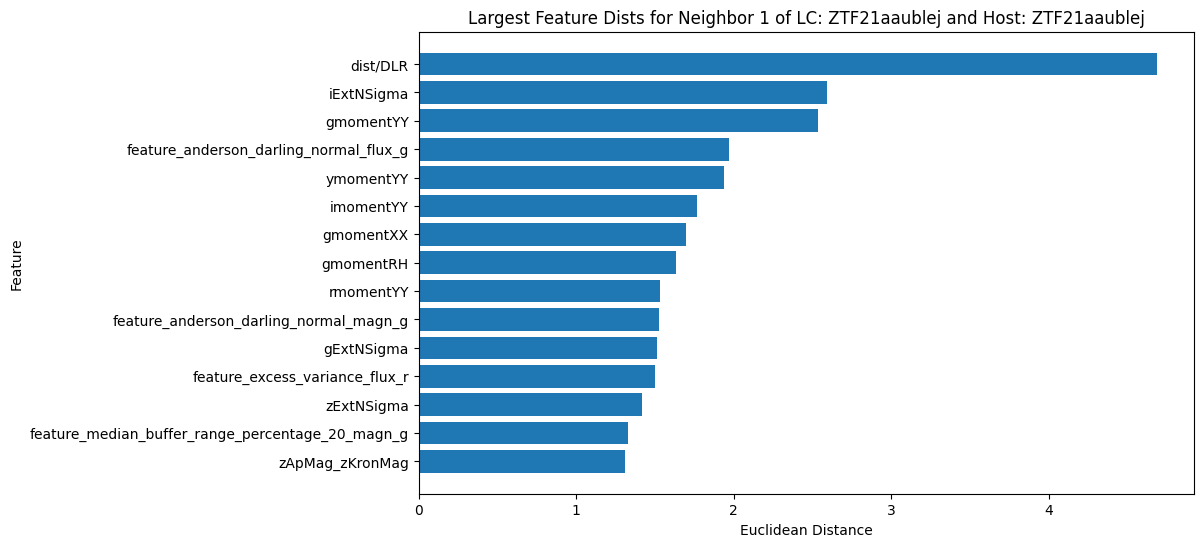

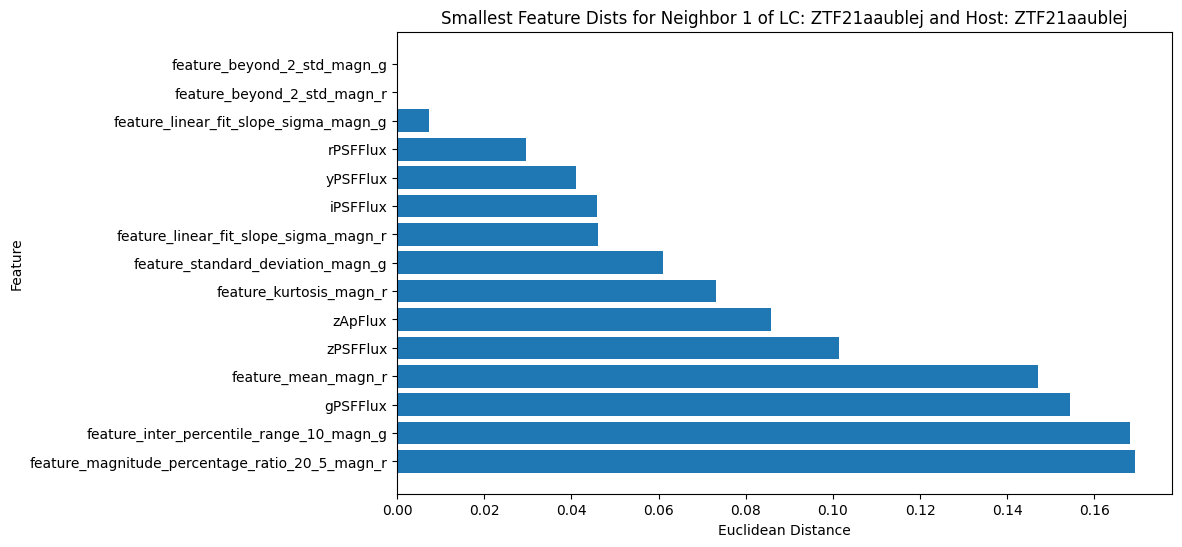

Neighbor ZTF ID: ZTF21aaublej


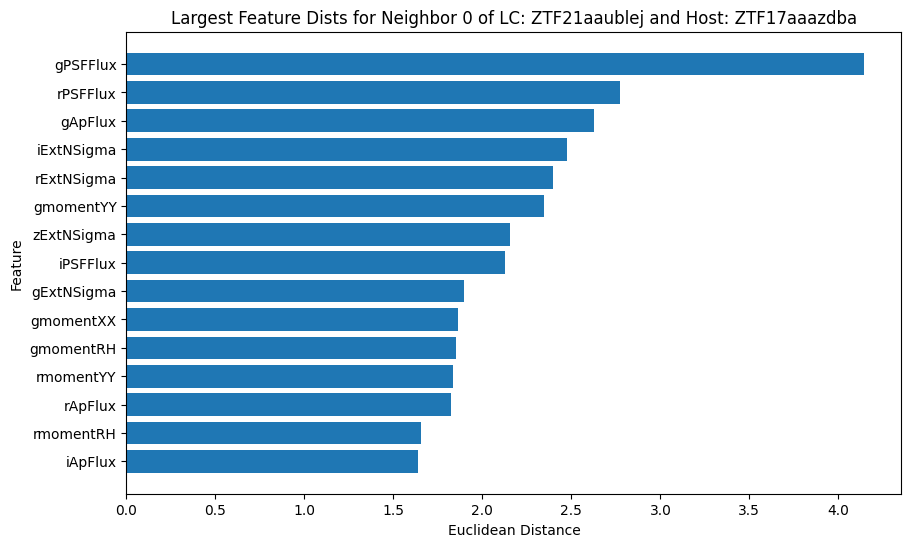

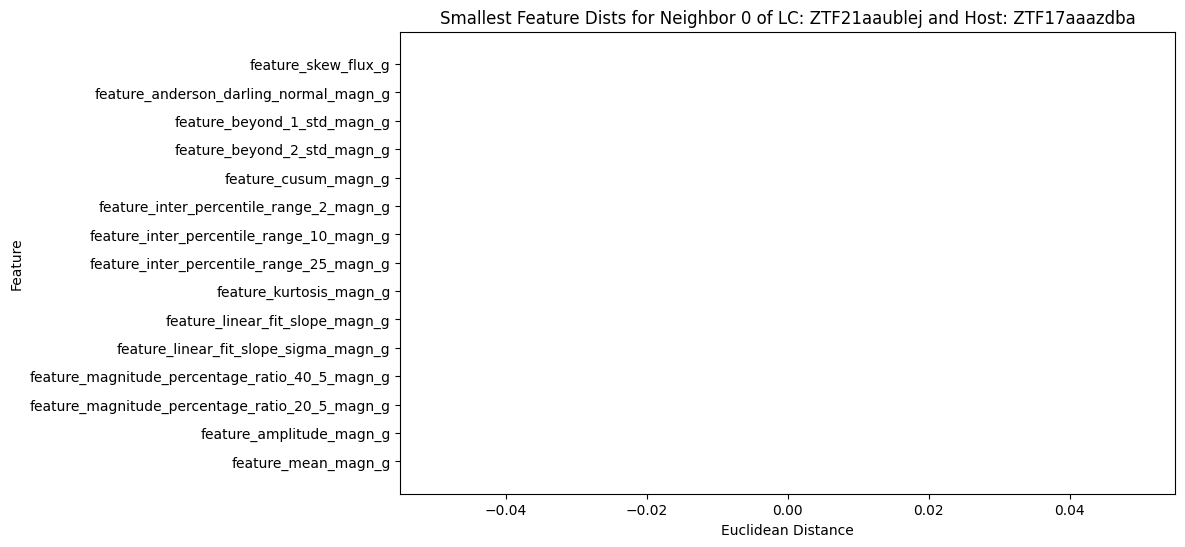

Neighbor ZTF ID: ZTF21aatlesr


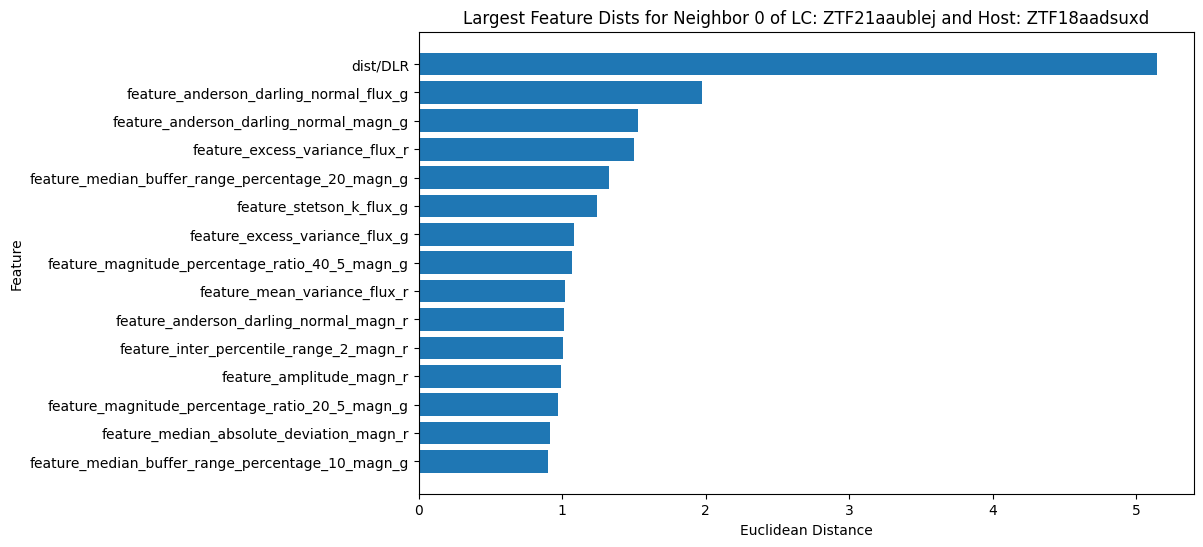

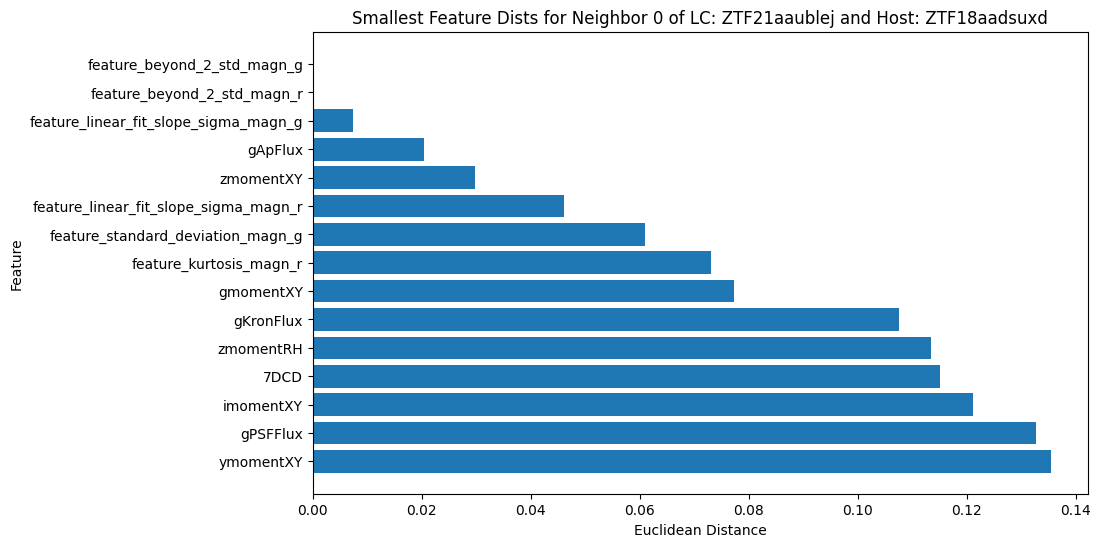

In [86]:
def PlotNeighborDists(lightcurve_ztf_id, host_ztf_id, laiss_feat_library_df, neighbors_df, feature_stats, neighbor_ztf = None, neighbor_num=0):
    
    # Get lightcurve and host features for input transient
    lc_feats = laiss_feat_library_df.loc[
        laiss_feat_library_df['ztf_id'] == lightcurve_ztf_id
    ].iloc[:, 59:].to_numpy().flatten()
    
    host_feats = laiss_feat_library_df.loc[
        laiss_feat_library_df['ztf_id'] == host_ztf_id
    ].iloc[:, 1:59].to_numpy().flatten()
    
    input_transient_feats = np.concatenate((lc_feats, host_feats))
    # Standardize features
    input_transient_feats = (input_transient_feats - feature_stats['Mean'].values) / feature_stats['Standard Deviation'].values
    
    if neighbor_ztf is None:
        # Get the neighbor_ztf_id for the given neighbor_num
        neighbor_ztf_id_link = neighbors_df.loc[
            (neighbors_df['lightcurve_ztf'] == lightcurve_ztf_id) &
            (neighbors_df['host_ztf'] == host_ztf_id) &
            (neighbors_df['neighbor_num'] == neighbor_num), 
            'ztf_link'
        ].iloc[0]
        neighbor_ztf_id = neighbor_ztf_id_link[neighbor_ztf_id_link.find('ZTF'):]
    else:
        neighbor_ztf_id = neighbor_ztf
        neighbor_num = neighbor_ztf
    print(f"Neighbor ZTF ID: {neighbor_ztf_id}")
    
    # Get lightcurve and host features for neighbor
    neighbor_lc_feats = laiss_feat_library_df.loc[
        laiss_feat_library_df['ztf_id'] == neighbor_ztf_id
    ].iloc[:, 59:].to_numpy().flatten()

    neighbor_host_feats = laiss_feat_library_df.loc[
        laiss_feat_library_df['ztf_id'] == neighbor_ztf_id
    ].iloc[:, 1:59].to_numpy().flatten()

    neighbor_transient_feats = np.concatenate((neighbor_lc_feats, neighbor_host_feats))
    # Standardize features
    neighbor_transient_feats = (neighbor_transient_feats - feature_stats['Mean'].values) / feature_stats['Standard Deviation'].values
    
    # Get feature-wise distances
    distances = np.abs(input_transient_feats - neighbor_transient_feats)
    
    # Return dataframe of features and distances
    feature_names = (
        list(laiss_feat_library_df.columns[59:]) + 
        list(laiss_feat_library_df.columns[1:59])
    )
    
    distance_df = pd.DataFrame({
        'feature': feature_names,
        'euclidean_distance': distances
    })
    sorted_distance_df = distance_df.sort_values(by='euclidean_distance', ascending=False)
    largest_distances = sorted_distance_df.head(15)
    smallest_distances = sorted_distance_df.tail(15)
    
    # Plot largest distances
    plt.figure(figsize=(10, 6))
    plt.barh(largest_distances['feature'], largest_distances['euclidean_distance'])
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Feature')
    plt.title(f'Largest Feature Dists for Neighbor {neighbor_num} of LC: {lightcurve_ztf_id} and Host: {host_ztf_id}')
    plt.gca().invert_yaxis()  # Invert y-axis for better visual order
    plt.show()

    # Plot smallest distances
    plt.figure(figsize=(10, 6))
    plt.barh(smallest_distances['feature'], smallest_distances['euclidean_distance'])
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Feature')
    plt.title(f'Smallest Feature Dists for Neighbor {neighbor_num} of LC: {lightcurve_ztf_id} and Host: {host_ztf_id}')
    plt.show()
    
    return distance_df

file_names = [
    'transient_feature_lib0.csv',
    'transient_feature_lib1500.csv',
    'transient_feature_lib2500.csv',
    'transient_feature_lib3000.csv',
    'transient_feature_lib4000.csv',
    'transient_feature_lib5000.csv'
]

# This dataframe has one row for every transient and 121 columns (first column is ztf_id)
laiss_feat_library_df = pd.concat([pd.read_csv("../"+file) for file in file_names], ignore_index=True)
# This dataframe has lightcurve-host swaps for ZTF21aaublej and ZTF22abcvfgs
neighbors_df = pd.read_csv('../data/neighbors_lib.csv')

dataset_bank_df = pd.read_csv("../dataset_bank_tns_cls.csv")
feature_columns = dataset_bank_df.columns[1:-1]

## This uses the dataset bank for standardizing features
# feature_stats_df = dataset_bank_df[feature_columns].agg(['mean', 'std']).transpose()
# feature_stats_df.columns = ['Mean', 'Standard Deviation']
temp_dataset_bank_df = dataset_bank_df[dataset_bank_df[feature_columns]['dist/DLR'] >= 50]#max(dataset_bank_df[feature_columns]['dist/DLR'])]
print(f"Problem lightcurves: {temp_dataset_bank_df['ztf_object_id'].tolist()} Dist/DLR values: {temp_dataset_bank_df['dist/DLR'].tolist()}")

## This uses laiss feature library (that you made) for standardizing features
feature_stats_df = laiss_feat_library_df[feature_columns].agg(['mean', 'std']).transpose()
feature_stats_df.columns = ['Mean', 'Standard Deviation']

# print(np.max(dataset_bank_df[feature_columns]['dist/DLR']))
# print(np.min(laiss_feat_library_df[feature_columns]['dist/DLR']))
# feature_stats_df.insert(0, 'Feature', feature_columns)
# feature_stats_df.to_csv('../check_feature_stats_for_standardization.csv', index=False)


distances_df = PlotNeighborDists(
    lightcurve_ztf_id="ZTF21aaublej", # ZTF21aaublej or ZTF22abcvfgs
    host_ztf_id="ZTF21aaublej", # ZTF17aaazdba (picks lightcurve as neighbor 0) or ZTF18aadsuxd (picks 2021ipb as neighbor 0, lightcurve itself is not in neighbor set at all)
    laiss_feat_library_df=laiss_feat_library_df,
    neighbors_df=neighbors_df,
    feature_stats=feature_stats_df,
    neighbor_ztf= None, # None, or compare to an input neighbor like 'ZTF21aaublej'
    neighbor_num=1, # Required if neighbor_ztf is not None. Starts counting from 0
)

distances_df = PlotNeighborDists(
    lightcurve_ztf_id="ZTF21aaublej", # ZTF21aaublej or ZTF22abcvfgs
    host_ztf_id="ZTF17aaazdba", # ZTF17aaazdba (picks lightcurve as neighbor 0) or ZTF18aadsuxd (picks 2021ipb as neighbor 0, lightcurve itself is not in neighbor set at all)
    laiss_feat_library_df=laiss_feat_library_df,
    neighbors_df=neighbors_df,
    feature_stats=feature_stats_df,
    neighbor_ztf= None, # None, or compare to an input neighbor like 'ZTF21aaublej'
    neighbor_num=0, # Required if neighbor_ztf is not None. Starts counting from 0
)

distances_df = PlotNeighborDists(
    lightcurve_ztf_id="ZTF21aaublej", # ZTF21aaublej or ZTF22abcvfgs
    host_ztf_id="ZTF18aadsuxd", # ZTF17aaazdba (picks lightcurve as neighbor 0) or ZTF18aadsuxd (picks 2021ipb as neighbor 0, lightcurve itself is not in neighbor set at all)
    laiss_feat_library_df=laiss_feat_library_df,
    neighbors_df=neighbors_df,
    feature_stats=feature_stats_df,
    neighbor_ztf= None, # None, or compare to an input neighbor like 'ZTF21aaublej'
    neighbor_num=0, # Required if neighbor_ztf is not None. Starts counting from 0
)


#### Feature plotter, excluding supernovae types

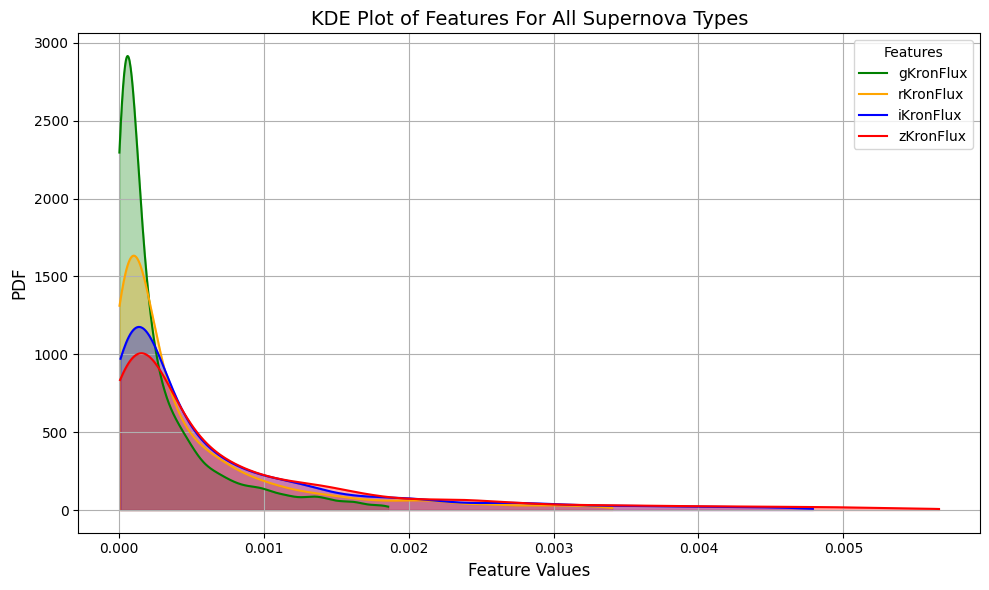

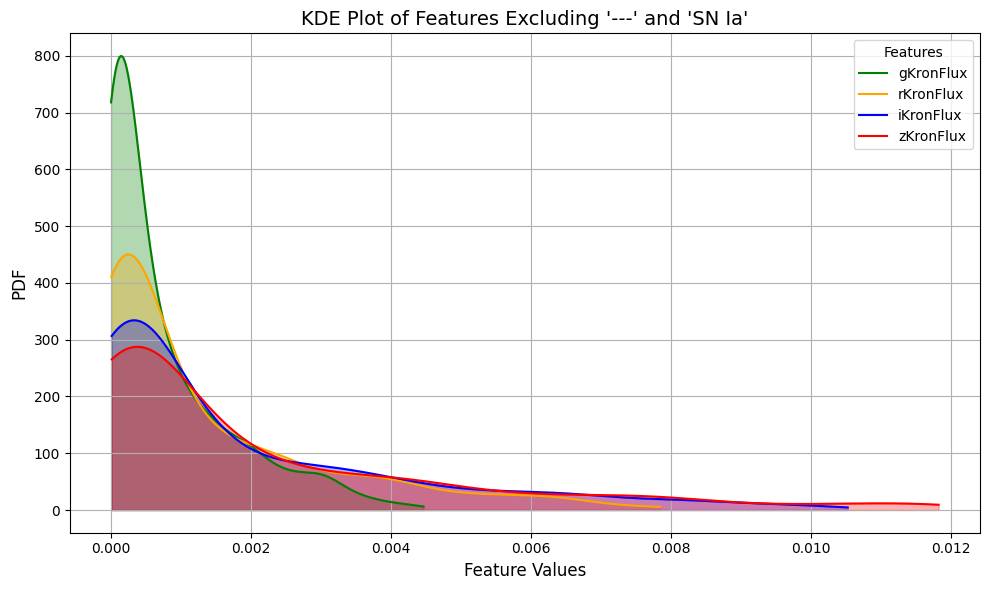

In [5]:
def plot_feat_kde(df, features, exclude_types=None, lower_percentile=0, upper_percentile=95):
    if exclude_types:
        df = df[~df['type'].isin(exclude_types)]
    
    plt.figure(figsize=(10, 6))
    colors = ['green', 'orange', 'blue', 'red'] 
    for idx, feature in enumerate(features):
        if feature not in df.columns:
            raise ValueError(f"The feature '{feature}' does not exist in the DataFrame.")
        
        lower_bound = np.percentile(df[feature].dropna(), lower_percentile)
        upper_bound = np.percentile(df[feature].dropna(), upper_percentile)
        filtered_data = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)][feature].dropna()
        
        if len(filtered_data) > 1:  # Ensure enough data for KDE
            kde = gaussian_kde(filtered_data)
            x_range = np.linspace(filtered_data.min(), filtered_data.max(), 500)
            y_values = kde(x_range)
            
            plt.plot(x_range, y_values, label=feature, color=colors[idx])
            plt.fill_between(x_range, y_values, alpha=0.3, color=colors[idx])
    
    title_suffix = "Excluding '---' and 'SN Ia'" if exclude_types else "For All Supernova Types"
    plt.title(f"KDE Plot of Features {title_suffix}", fontsize=14)
    plt.xlabel("Feature Values", fontsize=12)
    plt.ylabel("PDF", fontsize=12)
    plt.legend(title="Features", loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

features = ['gKronFlux', 'rKronFlux', 'iKronFlux', 'zKronFlux']
exclude_types = ['---', 'SN Ia']
plot_feat_kde(df_bank_tns_cls, features)
plot_feat_kde(df_bank_tns_cls, features, exclude_types=exclude_types)
